# Podstawy Sztucznej Inteligencji
## Kacper Marzol

Celem tego projektu jest klasyfikacja piosenek na podstawie ich kilku cech. Zbiór danych składa się z 278 tysięcy piosenek z serwisu Spotify. Dla szybkości obliczeń użyjemy niepełnych danych.

Zródło danych (serwis Kaggle): <https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset>

In [1]:
import pandas as pd

data = pd.read_csv("data/278k_labelled_uri.csv")
data=data.iloc[:30000, :]

# Wybieramy próbkę o liczebności 30000, by skrócić czas uczenia

In [2]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'duration (ms)', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'spec_rate', 'labels', 'uri'],
      dtype='object')

## Objaśnienie poszczególnych cech

* **Acousticness**: miara akustyczności od 0 do 1
* **Danceability**: miara taneczności od 0 do 1
* **Energy:** miara energiczności od 0 do 1
* **Instrumentalness:** miara instrumentalności od 0 do 1
* **Liveness:** miara obecności publiki w nagraniu od 0 do 1
* **Loudness:** miara głośnośći w decybelach (-60 do 0 decybeli)
* **Speechiness:** miara słów w piosence od 0 do 1
* **Valence:** miara od 0 do 1 opisująca pozytywność przekazywaną przez piosenkę
* **Tempo:** tempo piosenki w BMP (uderzeń na minutę)

## Statytyki danych

In [3]:
data.labels.unique()

array([2, 1, 0, 3])

### Objaśnienia poszczególnych labeli:

* 0 - piosenka smutna
* 1 - piosenka wesoła
* 2 - piosenka energetyczna
* 3 - piosenka spokojna

In [4]:
mapping = {0: 'piosenka smutna',
           1: 'piosenka wesoła',
           2: 'piosenka energiczna',
           3: 'piosenka spokojna'}


value_counts = pd.DataFrame(data.labels.map(mapping).value_counts())
value_counts=value_counts.rename(columns = {'labels' : 'ilość wystąpień'}) 
value_counts

,ilość wystąpień
piosenka smutna,9840
piosenka wesoła,8824
piosenka energiczna,8239
piosenka spokojna,3097


Usuniemy zbędne kolumny, "uri", ponieważ URL piosenki nie jest potrzebny oraz dwie pierwsze kolumny

In [5]:
cols_to_drop=["Unnamed: 0.1", "Unnamed: 0","uri"]
data=data.drop(cols_to_drop ,axis=1)

In [6]:
data.head()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


Dodamy trochę nanów do zbioru

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

X = data.drop('labels', axis=1)
y = data.labels

ix = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    X.iat[row, col] = np.nan

X.isna().sum()

duration (ms)       2963
danceability        2996
energy              3122
loudness            2964
speechiness         2939
acousticness        3081
instrumentalness    3075
liveness            2937
valence             2894
tempo               3000
spec_rate           3029
dtype: int64

Podzielimy zbiór na część treningową, walidacyjną i testową:

In [8]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(X_val.shape)

(24000, 11)
(24000,)
(3000, 11)
(3000, 11)


### Udział procentowy poszczególnych zbiorów:
* Zbiór treningowy - 80%
* Zbiór walidacyjny - 10%
* Zbiór testowy - 10%

### Pairplot dla 300 początkowych próbek ze zbioru treningowego 

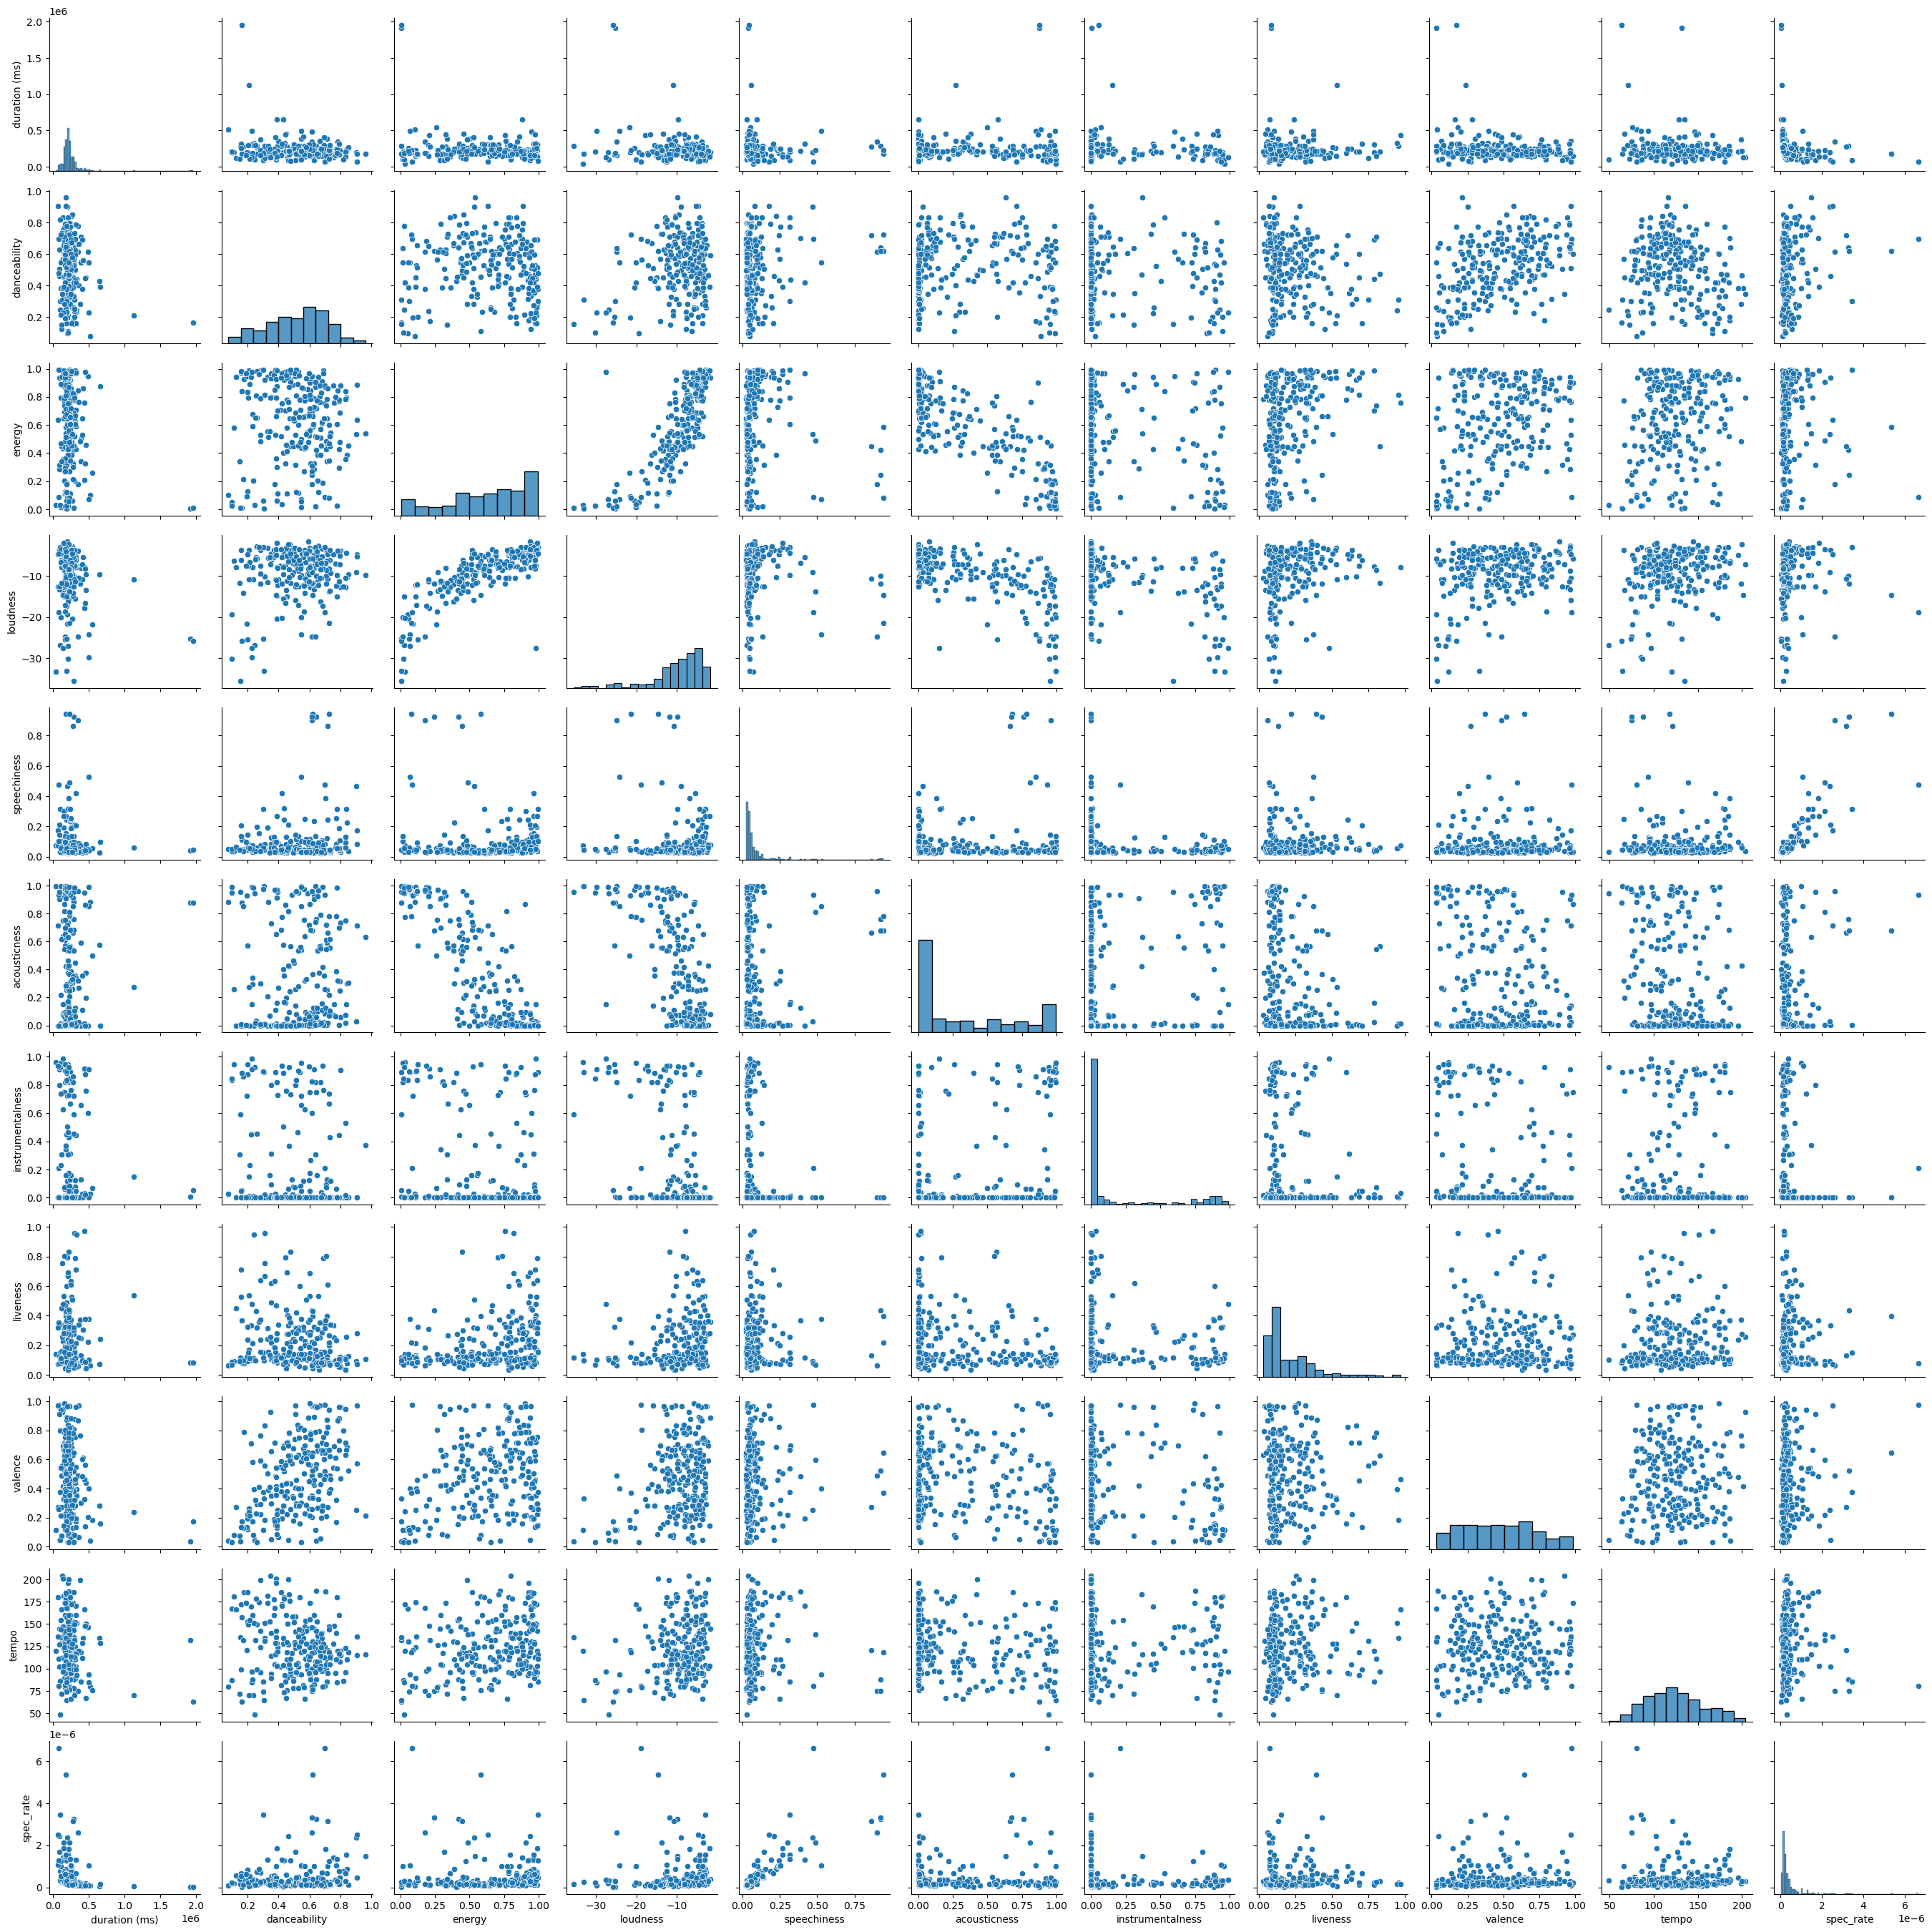

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

xplot=X_train.iloc[:300, :]
sns.pairplot(xplot)
plt.show()

### Macierz korelacji poszczególnych cech

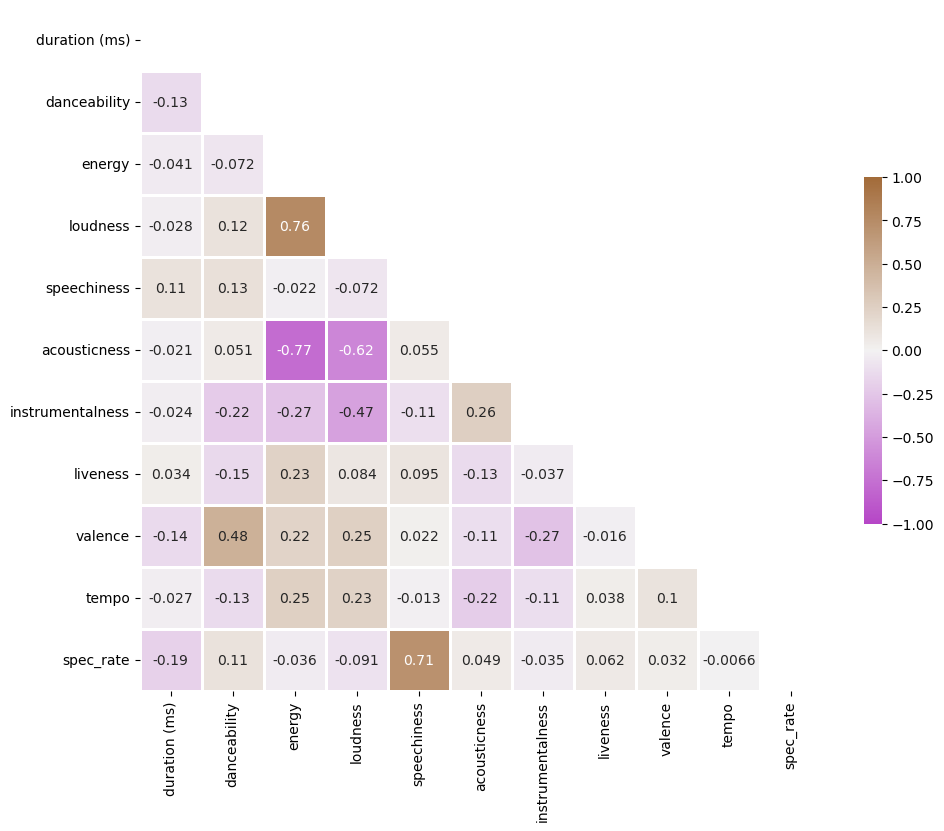

In [10]:
corr = X_train.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300,400 , as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1,
            square=True, xticklabels=1, yticklabels=1,
            linewidths=1, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

Zauważamy kilka dodatnich i wysokich korelacji, które wydają się oczywiste (np. loudness i energy) oraz ujemnych (loudness i acousticness). Na ogół jednak dane nie są skorelowane.

# Nauczymy kilka modeli

### Przygotowanie do uczenia 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# początkowo puste listy na modele, ich nazwy, oraz obliczone accurracy na zbiorze walidacyjnym
models=[]
model_names=[]
accuracy=[]

In [12]:
# funkcja, która tworzy pipeline z Simple Imputerem, Standard Scalerem, oraz przesłanym modelem
def pipeline_maker(model):
    return make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), model)


# funkcja, która wykonuje grid search na przesłanym modelu oraz gridzie parametrów, zwraca model
# z najlepszymi parametrami oraz wyniki grid searcha
def test (model, param_grid_):
    pipe=pipeline_maker(model)
    search=GridSearchCV(pipe, param_grid=param_grid_,scoring='accuracy')
    search.fit(X_train, y_train)
    return search.best_estimator_, search.cv_results_

# funkcja do tworzenia heatmapy
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5) 
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

# Logistic Regression

### Trening

In [13]:
logistic=LogisticRegression()

param_grid={
    'simpleimputer__strategy': ['mean', 'median'],
    "logisticregression__C": [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    }

logistic, scores = test(logistic, param_grid)

results = pd.DataFrame(scores)

models.append(logistic)
model_names.append("Logistic Regression")
y_pred=logistic.predict(X_val)
accuracy.append(accuracy_score(y_val,y_pred))

### Prezentacja wyników

In [14]:
print(logistic)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])


##### Classification report

In [15]:
print("accuracy: " , accuracy[-1])
cr= classification_report(y_val, y_pred,  output_dict=True)
cr['0']

accuracy:  0.792


{'precision': 0.805,
 'recall': 0.782312925170068,
 'f1-score': 0.7934943321833415,
 'support': 1029}

##### Heatmapa dla poszczególnych hiperparametrów 

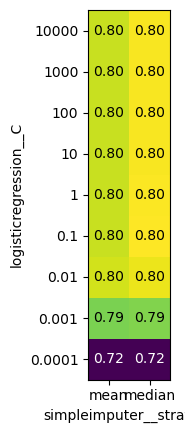

In [16]:
scores = np.array(results.mean_test_score).reshape(9, 2, 1)
scores = scores[:,:,0]

heatmap(scores, xlabel='simpleimputer__strategy', xticklabels=param_grid['simpleimputer__strategy'],
        ylabel='logisticregression__C', yticklabels=param_grid['logisticregression__C'], cmap="viridis")

plt.show()

##### Confusion Matrix

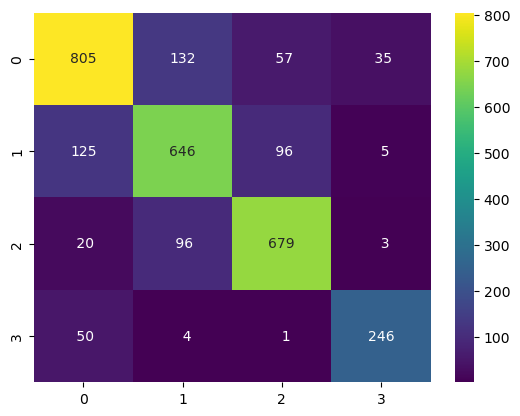

In [17]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

Accuracy wynosi 0.792 , widzimy, że model stosunkowo często myli piosenki oznaczone jako 1, z tymi, które mają labele 0 i 2, czyli piosenki, które są wesołe ze smutnymi i energicznymi.

##### Wykres współrzędnych wykorzystanych przez model:

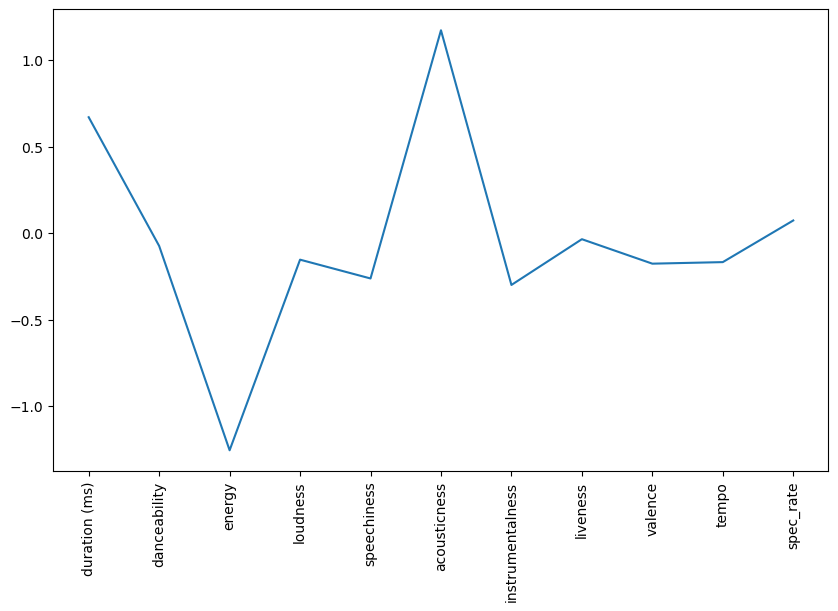

In [18]:
f, ax = plt.subplots(1,1,figsize=(10,6))

x=range(11)

columns = X.columns.tolist()

w=logistic["logisticregression"].coef_[0].reshape(-1,1)
ax.plot(x,w)

ax.set_xticks(x)
ax.set_xticklabels(columns,rotation=90)

plt.show()

# Random Forests

### Trening

In [19]:
rfc=RandomForestClassifier()

param_grid = {
    'randomforestclassifier__n_estimators': [10,20,30],
    'randomforestclassifier__max_depth': [None, 5, 10,15],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5]
    }

rfc, scores = test(rfc, param_grid)

results = pd.DataFrame(scores)

y_pred=rfc.predict(X_val)
models.append(rfc)
model_names.append("Random Forest Classifier")
accuracy.append(accuracy_score(y_val,y_pred))

### Prezentacja wyników

In [20]:
print(rfc)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=10,
                                        n_estimators=30))])


##### Classification Report

In [21]:
print("accuracy: " , accuracy[-1])
cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.8683333333333333


{'precision': 0.8722592945662536,
 'recall': 0.8892128279883382,
 'f1-score': 0.8806544754571705,
 'support': 1029}

##### Confusion Matrix

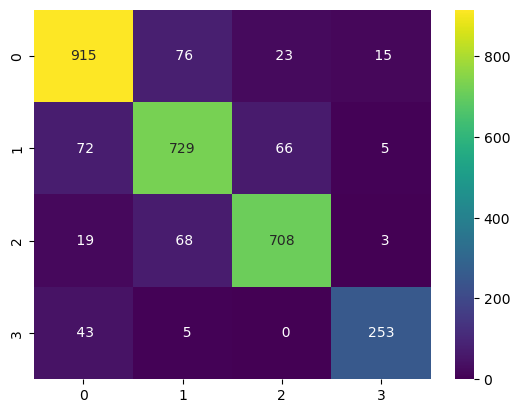

In [22]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

Uzyskaliśmy wysokie accuracy, oraz f1 score, w confusion matrix zauważamy jednak podobny problem co poprzednio -
mylenie piosenek, które są wesołe, z tymi, które są smutne i energiczne.

# SVM

### Trening

In [23]:
svc = SVC()

param_grid = {
    'svc__C': [0.001,0.01,0.1, 1, 10,100],
    'svc__kernel': ['linear', 'rbf','sigmoid'],
    'svc__gamma': [0.001,0.01,0.1, 1, 10,100]
    }

svc, scores = test(svc, param_grid)

results = pd.DataFrame(scores)

y_pred=svc.predict(X_val)

models.append(svc)
model_names.append("SVC")
accuracy.append(accuracy_score(y_val,y_pred))

### Prezentacja wyników

In [24]:
print(svc)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=0.1))])



##### Classification report

In [25]:
print("accuracy: " , accuracy[-1])
cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.8236666666666667


{'precision': 0.8477406679764243,
 'recall': 0.8386783284742468,
 'f1-score': 0.8431851489985346,
 'support': 1029}

##### Confusion Matrix

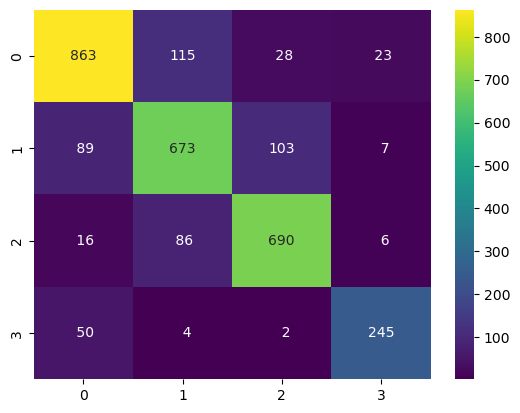

In [26]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

W Confusion Matrix zauważamy te same pomyłki co wcześniej.

# KNN

### Trening

In [27]:
knn = KNeighborsClassifier()

param_grid = {
    'kneighborsclassifier__n_neighbors': [5,10,15,20,25],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    }

knn, results = test(knn, param_grid)

results = pd.DataFrame(results)

y_pred=knn.predict(X_val)

models.append(knn)
model_names.append("K Nearest Neigbours")
accuracy.append(accuracy_score(y_val, y_pred))

### Prezentacja wyników

In [28]:
print(knn)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=20, weights='distance'))])


##### Classification report

In [29]:
print("accuracy: " , accuracy[-1])
cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.799


{'precision': 0.824847250509165,
 'recall': 0.7871720116618076,
 'f1-score': 0.8055693684733963,
 'support': 1029}

##### Heatmapa dla poszczególnych hiperparametrów 

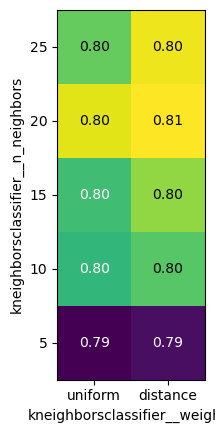

In [30]:
scores = np.array(results.mean_test_score).reshape(5, 2, 1)
scores = scores[:,:,0]

heatmap(scores, xlabel='kneighborsclassifier__weights', xticklabels=param_grid['kneighborsclassifier__weights'], ylabel='kneighborsclassifier__n_neighbors', yticklabels=param_grid['kneighborsclassifier__n_neighbors'], cmap="viridis")
plt.show()

##### Confusion Matrix

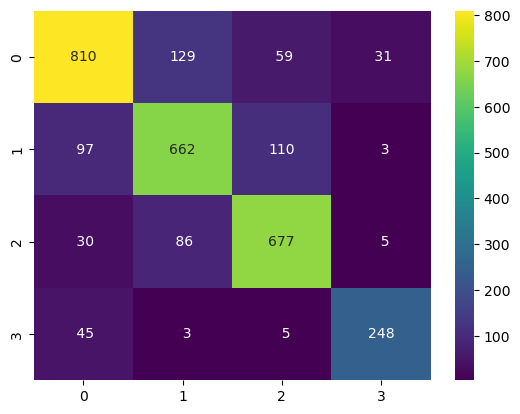

In [31]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()


# Decision Tree

### Trening

In [32]:
dtc = DecisionTreeClassifier()

param_grid = {
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 7, 10,12,14],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4,6,8],
    }

dtc, results = test(dtc, param_grid)

results = pd.DataFrame(results)

y_pred=dtc.predict(X_val)
models.append(dtc)
model_names.append("Decision Trees")
accuracy.append(accuracy_score(y_val,y_pred))

### Prezentacja wyników

In [33]:
print(dtc)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=8,
                                        min_samples_split=5))])


##### Classification report

In [34]:
print("accuracy: " , accuracy[-1])
cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.8253333333333334


{'precision': 0.8290598290598291,
 'recall': 0.8483965014577259,
 'f1-score': 0.8386167146974065,
 'support': 1029}

##### Confusion Matrix

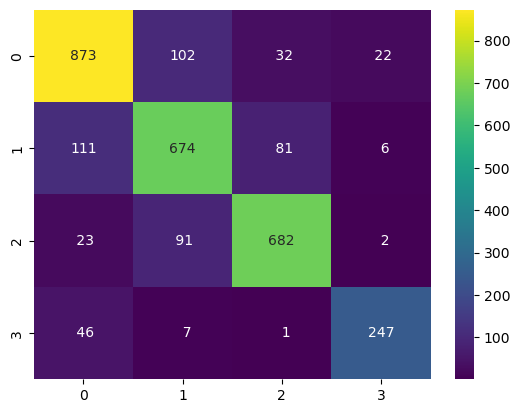

In [35]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

***

### Porównajmy teraz nasze modele:

In [36]:
df={'model' : model_names, 'accuracy ' : accuracy}
df=pd.DataFrame(df)
df

,model,accuracy
0,Logistic Regression,0.792000
1,Random Forest Classifier,0.868333
2,SVC,0.823667
3,K Nearest Neigbours,0.799000
4,Decision Trees,0.825333


Po sprawdzeniu kilku klasyfikatorów, zauważamy, że niektóre radzą sobie lepiej, wybierzemy 3 i stworzymy komitet głosujący

In [37]:
voting_classifier = VotingClassifier(
    estimators=[('rfc', rfc), ('svc', svc), ('dt', dtc)],
    voting='hard' )

voting_classifier.fit(X_train,y_train)

VotingClassifier(estimators=[('rfc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(min_samples_leaf=2,
                                                                      min_samples_split=10,
                                                                      n_estimators=30))])),
                             ('svc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('svc', SVC(C=10, gamma=0.1))])),
                             ('dt',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('decisiontreeclassifier',
                                               DecisionTreeClassifier(max_depth=15,
                                                                      min_samples_leaf=8,
                                                                      min_samples_split=5))]))])

In [38]:
y_pred=voting_classifier.predict(X_val)
print("accuracy: ", accuracy_score(y_val, y_pred))

cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.858


{'precision': 0.8648905803996194,
 'recall': 0.8833819241982507,
 'f1-score': 0.8740384615384614,
 'support': 1029}

Wynik komitetu jest wyższy niż SVC oraz Decision Trees osobno, jednak nie jest tak dobry jak Random Forest, być może komitet złożony ze wszystkich klasyfikatorów okaże się lepszy?

In [39]:
voting_classifier2 = VotingClassifier(
    estimators=[('rfc', rfc), ('svc', svc), ('dt', dtc), ('lr', logistic), ('knn', knn)],
    voting='hard' )

voting_classifier2.fit(X_train,y_train)

VotingClassifier(estimators=[('rfc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(min_samples_leaf=2,
                                                                      min_samples_split=10,
                                                                      n_estimators=30))])),
                             ('svc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardS...
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.1))])),
                             ('knn',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_neighbors=20,
                                                                    weights='distance'))]))])

In [40]:
y_pred=voting_classifier2.predict(X_val)
print("accuracy: ", accuracy_score(y_val, y_pred))

cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

accuracy:  0.8373333333333334


{'precision': 0.8504854368932039,
 'recall': 0.8513119533527697,
 'f1-score': 0.8508984944147644,
 'support': 1029}

Niestety nie, Random Forest jak dotąd wygrywa pojedynek.

# Sprawdźmy jeszcze modele oparte na sieciach neuronowych

### Przygotowanie do uczenia

In [41]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from sklearn.impute import KNNImputer
from keras.layers import Dense
from keras.layers import InputLayer
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Normalization
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

# Brakujące wartości uzupełnimy za pomocą KNNImputera
imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train)
X_train_imputer=imputer.transform(X_train)
X_val_imputer=imputer.transform(X_val)
X_test_imputer=imputer.transform(X_test)

# funkcja Step Decay do Learning Rate Scheduler
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate



### Na początek prosty model

In [42]:
## 2 warstwy ukryte, funkcja aktywacji ReLU

model1 = Sequential([
    Dense(400, activation="relu", input_shape=(11,)),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(4, activation="softmax")
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               4800      
                                                                 
 dense_1 (Dense)             (None, 300)               120300    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 4)                 404       
                                                                 
Total params: 155,604
Trainable params: 155,604
Non-trainable params: 0
_________________________________________________________________


In [43]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [44]:
history1 = model1.fit(X_train_imputer, y_train, epochs=20,
                    validation_data=(X_val_imputer, y_val))

Epoch 1/20


2023-06-25 14:58:34.904296: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 1s 1ms/step - loss: 945.2028 - accuracy: 0.2817 - val_loss: 227.5546 - val_accuracy: 0.3430
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 26.9874 - accuracy: 0.2889 - val_loss: 12.3760 - val_accuracy: 0.2660
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 4.3035 - accuracy: 0.3179 - val_loss: 1.2961 - val_accuracy: 0.3077
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 1.3986 - accuracy: 0.3149 - val_loss: 1.3713 - val_accuracy: 0.2907
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 1.3387 - accuracy: 0.2937 - val_loss: 1.3209 - val_accuracy: 0.2907
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 1.3185 - accuracy: 0.3160 - val_loss: 1.3115 - val_accuracy: 0.3430
Epoch 7/20
750/750 [==============================] - 1s 1ms/step - loss: 1.3157 - accuracy: 0.3263 - val_loss: 1.3100 - val_accuracy: 0.3430
Epoch 8/20


Otrzymaliśmy nienajlepszy wynik, spróbujmy znormalizować dane za pomocą Batch Normalization:

In [45]:
# 2 warstwy ukryte, Batch Normalization, funkcja aktywacji ReLU

model2 = Sequential([
    Dense(500, use_bias=False, input_shape=(11,)),
    BatchNormalization(),
    Activation('relu'),
    Dense(250, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dense(125, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dense(4, activation="softmax")
])

model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


history2 = model2.fit(X_train_imputer, y_train, epochs=40,
                    validation_data=(X_val_imputer, y_val))

Epoch 1/40
750/750 [==============================] - 2s 2ms/step - loss: 1.2861 - accuracy: 0.3652 - val_loss: 1.3416 - val_accuracy: 0.2877
Epoch 2/40
750/750 [==============================] - 1s 2ms/step - loss: 1.2749 - accuracy: 0.3697 - val_loss: 1.2776 - val_accuracy: 0.3620
Epoch 3/40
750/750 [==============================] - 1s 2ms/step - loss: 1.2699 - accuracy: 0.3779 - val_loss: 1.2638 - val_accuracy: 0.3843
Epoch 4/40
750/750 [==============================] - 1s 2ms/step - loss: 1.2658 - accuracy: 0.3823 - val_loss: 1.3610 - val_accuracy: 0.2960
Epoch 5/40
750/750 [==============================] - 1s 2ms/step - loss: 1.2311 - accuracy: 0.4091 - val_loss: 1.7410 - val_accuracy: 0.1003
Epoch 6/40
750/750 [==============================] - 1s 2ms/step - loss: 1.2077 - accuracy: 0.4183 - val_loss: 1.6672 - val_accuracy: 0.3053
Epoch 7/40
750/750 [==============================] - 1s 2ms/step - loss: 1.1596 - accuracy: 0.4542 - val_loss: 2.8697 - val_accuracy: 0.2693
Epoch 

Niewiele lepiej, być może problem tkwi w nieznormalizowanych danych wejściowych. Długośc piosenki podawana jest w ms, więc przyjmuje bardzo duże wartości, z kolei większość pozostałych cech ma zakres 0-1. Spróbujmy stworzyć rozbudowany model

In [46]:
# warstwa normalizacyjna
normalizer = Normalization()
normalizer.adapt(X_train_imputer)

# przykład znormalizowanych danych
xnorm = normalizer(X_train_imputer)
xnorm

<tf.Tensor: shape=(24000, 11), dtype=float32, numpy=
array([[-0.22861077,  1.6063912 ,  1.0111496 , ...,  2.0162964 ,
        -0.0767817 , -0.35726568],
       [ 0.41860008,  1.1108491 ,  0.6048133 , ...,  1.6781684 ,
        -0.99269986, -0.32847616],
       [-0.2107952 ,  1.6122073 , -1.377591  , ..., -0.0083483 ,
        -0.24295059, -0.20950438],
       ...,
       [ 0.68430305,  0.71069294,  0.58634347, ...,  1.0431476 ,
         0.29606086, -0.29988372],
       [-0.71180207,  0.08835743, -0.63266563, ..., -0.00257529,
        -1.7551383 , -0.23371948],
       [-0.8761086 ,  0.9142608 ,  0.56787366, ...,  0.46997926,
        -0.31253904,  1.8515424 ]], dtype=float32)>

In [47]:
# wartość średnia każdej kolumny jest między -1 a 1
print(np.mean(xnorm, axis=1))

[ 0.19300179  0.11781779  0.12997241 ...  0.06291071 -0.43978214
  0.2354258 ]


In [48]:
# 4 warstwy ukryte, Batch Normalization, Dropout, EarlyStopping, Learning Rate Scheduler, funkcja aktywacji ReLU

model3 = Sequential([
    normalizer,
    Dense(800, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(400, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(200, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(100, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(60, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(4, activation="softmax")
])

model3.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

history3 = model3.fit(X_train_imputer, y_train, epochs=100,
                    validation_data=(X_val_imputer, y_val), callbacks=[lrate, early_stopping])

Epoch 1/100
750/750 [==============================] - 3s 4ms/step - loss: 0.6380 - accuracy: 0.7512 - val_loss: 0.5585 - val_accuracy: 0.7833 - lr: 0.0100
Epoch 2/100
750/750 [==============================] - 3s 4ms/step - loss: 0.5899 - accuracy: 0.7704 - val_loss: 0.5080 - val_accuracy: 0.8010 - lr: 0.0100
Epoch 3/100
750/750 [==============================] - 3s 4ms/step - loss: 0.5702 - accuracy: 0.7795 - val_loss: 0.4568 - val_accuracy: 0.8080 - lr: 0.0100
Epoch 4/100
750/750 [==============================] - 3s 4ms/step - loss: 0.5622 - accuracy: 0.7807 - val_loss: 0.4885 - val_accuracy: 0.8000 - lr: 0.0100
Epoch 5/100
750/750 [==============================] - 3s 4ms/step - loss: 0.5501 - accuracy: 0.7832 - val_loss: 0.4515 - val_accuracy: 0.8130 - lr: 0.0100
Epoch 6/100
750/750 [==============================] - 3s 4ms/step - loss: 0.5399 - accuracy: 0.7893 - val_loss: 0.4739 - val_accuracy: 0.8140 - lr: 0.0100
Epoch 7/100
750/750 [==============================] - 3s 4ms/st

In [49]:
model3.evaluate(X_val_imputer, y_val)

94/94 [==============================] - 0s 756us/step - loss: 0.4091 - accuracy: 0.8323


[0.4091058373451233, 0.8323333263397217]

### Krzywe uczenia

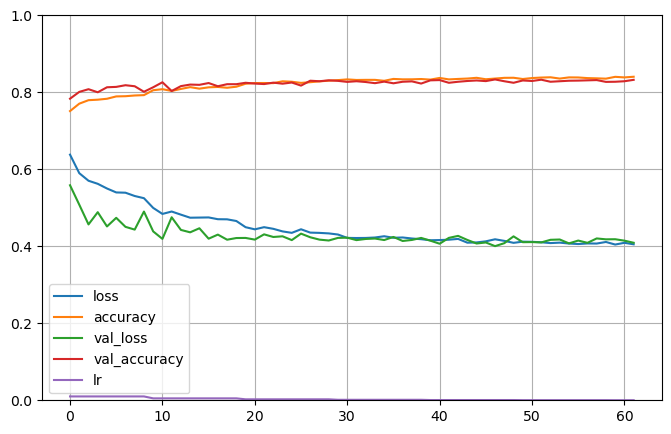

In [50]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Okazało się, że 2 najlepsze modele to Random Forest oraz Sieć neuronowa, przetestujemy je teraz na zbiorze testowym:

## Random Forest

In [51]:
y_pred_rfc=rfc.predict(X_test)

In [52]:
print(accuracy_score(y_test, y_pred_rfc))

0.883


## Sieć

In [62]:
model3.evaluate(X_test_imputer, y_test)

94/94 [==============================] - 0s 905us/step - loss: 0.3788 - accuracy: 0.8473


[0.37877094745635986, 0.8473333120346069]

Okazało się, że najlepszym klasyfikatorem w naszym przypadku jest Random Forest, który osiągnął bardzo dobry wynik 0.883.